# Geographical Indexing Explained

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [20]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

Geohash level 3 (0.7° by 0.7°)

https://stackoverflow.com/a/39540339/7195218

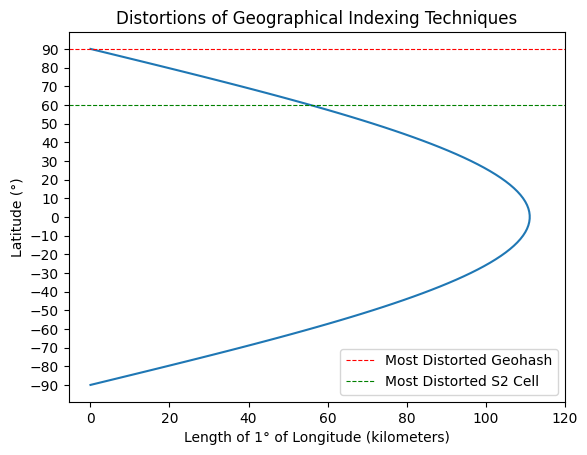

In [21]:
EARTH_RADIUS_KMS = 6371
latitude = np.linspace(-90, 90, 100)
one_degree_longitude_length = (np.pi / 180) * EARTH_RADIUS_KMS * np.cos(np.radians(latitude))
plt.plot(one_degree_longitude_length, latitude)
plt.xticks(np.arange(0, 140, 20))
plt.yticks(np.arange(-90, 100, 10))
plt.ylabel("Latitude (°)")
plt.xlabel("Length of 1° of Longitude (kilometers)")
plt.title("Distortions of Geographical Indexing Techniques")
plt.axhline(90, c="red", linestyle="dashed", linewidth=.8, label="Most Distorted Geohash")
plt.axhline(60, c="green", linestyle="dashed", linewidth=.8, label="Most Distorted S2 Cell")
plt.legend()
plt.savefig(os.path.join(images_dir, "longitude-distortion-of-geohash-s2.png"))
plt.show()

## S2

In [22]:
import s2cell

In [23]:
for level in range(1, 10):
    print(s2cell.lat_lon_to_cell_id(-11, 10, level))

2017612633061982208
1945555039024054272
1963569437533536256
1950058638651424768
1946680938930896896
1945836514000764928
1945625407768231936
1945642999954276352
1945647398000787456


## Z Order vs Hilbert Curve

https://github.com/trevorprater/pymorton

In [24]:
from hilbertcurve.hilbertcurve import HilbertCurve
import pymorton

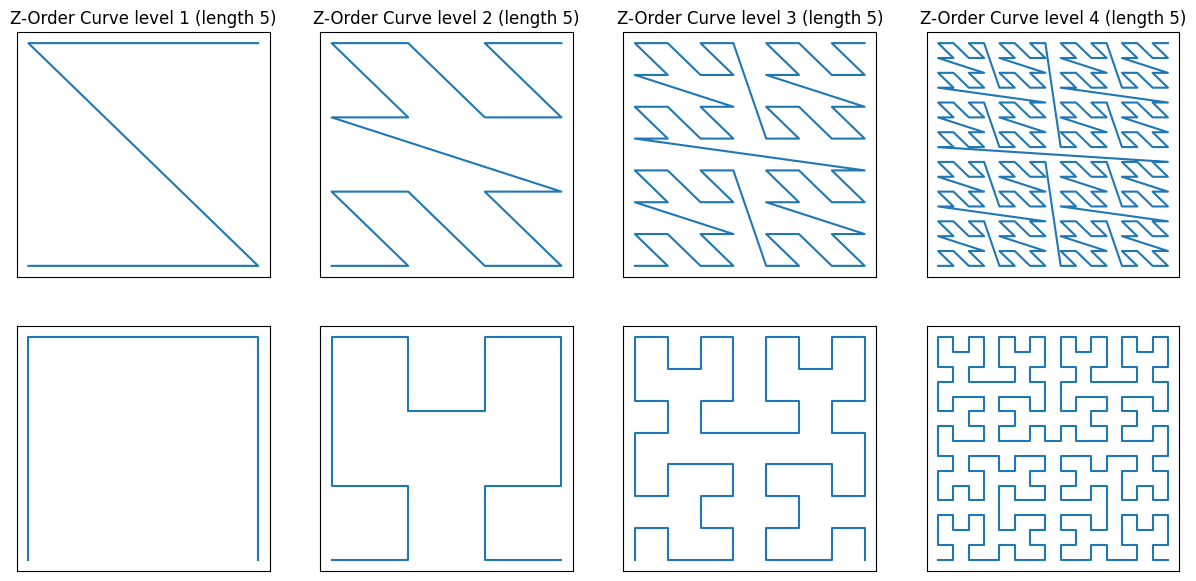

In [56]:
# set up the chart
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

# for three levels of the fractal curve
for i, curve_level in enumerate([1, 3, 5, 7]):

    # plot the Z Order Curve
    z_points = tuple(zip(*[pymorton.deinterleave2(index) for index in range(2 ** (curve_level + 1))]))
    axs[0, i].plot(*z_points)
    axs[0, i].set_title(f'Z-Order Curve, Level {i + 1} (length {})')

    # plot the Hilbert curve
    hilbert_curve = HilbertCurve(p=curve_level, n=2)
    distances = list(range(2 ** (curve_level + 1)))
    points = tuple(zip(*hilbert_curve.points_from_distances(distances)))
    x, y = (points[0], points[1]) if i % 2 == 0 else (points[1], points[0])
    axs[1, i].plot(x, y)

    # Clear axes
    for j in [0, 1]:
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

In [7]:
pymorton.deinterleave2(6)

(2, 1)